In [1135]:
import pandas as pd
import numpy as np
import pathlib
from ast import literal_eval
import graph_tool as gt
from graph_tool.all import graph_draw
import graph_tool.topology as gtt


In [1136]:
# df = pd.read_csv("../../data/sample_data.csv")
# df.drop(['message_id', 'milestone_index', 'datetime'], axis=1, inplace=True)

df = pd.read_csv("../../data/first_14_days_UTXO_txs_of_IOTA.csv")
df.drop(['message_id', 'milestone_index', 'datetime'], axis=1, inplace=True)

# df = pd.read_csv("../../data/btc.csv")
# df.drop(['Unnamed: 0.1', 'Unnamed: 0', 'block_index', 'timestamp'], axis=1, inplace=True)


In [1137]:
df_unique_tx_id = pd.DataFrame()
df_unique_tx_id['transaction_id'] = pd.unique(df[['transaction_id']].values.ravel())
df_unique_tx_id['tx_unique_id'] = df_unique_tx_id.index

pathlib.Path('../../logs/sample_logs/generated_files').mkdir(parents=True, exist_ok=True)
df_unique_tx_id.to_csv('../../logs/sample_logs/generated_files/transaction_ids.csv', index=False)


In [1138]:
df = df.merge(df_unique_tx_id, on='transaction_id', how='left')
df.drop(['transaction_id'], axis=1, inplace=True)

df = df[df['input_addresses_x'].str.contains("\[nan|nan,|, nan|nan]") == False]


In [1139]:
df_trial = df


In [1140]:
graph_of_correspondences = gt.Graph( directed=False )
nodes_dict = {}

# Setting properties of graph
vertex_property = graph_of_correspondences.new_vertex_property("string")
edge_property = graph_of_correspondences.new_edge_property("object")



In [1141]:
# def add_correspondence(
#                         row, graph_of_correspondences, 
#                         ip_addrs_idx, op_addrs_idx, 
#                         ip_amt_idx, op_amt_idx,
#                         nodes_dict,
#                         vertex_property,
#                         edge_property,
#                     ):

#     nodes_list = literal_eval(row[ip_addrs_idx]) # converts string to list form

#     ip_amt = literal_eval(row[ip_amt_idx])
#     op_amt = literal_eval(row[op_amt_idx])
#     op_addrs = literal_eval(row[op_addrs_idx])
#     h1 = 0
    
#     # h1 - get change address
#     if min(op_amt) < min(ip_amt): 
#         idx = np.argmin(op_amt)
#         change_addrs = op_addrs[idx]
#         nodes_list.append(change_addrs)
#         h1 = 1

#     nodes_list = set(nodes_list)

#     if len(nodes_list) <= 1: return

#     for node in nodes_list :
#         if node in nodes_dict: continue
#         vertex = graph_of_correspondences.add_vertex()
#         idx = graph_of_correspondences.vertex_index[vertex]
#         nodes_dict[node] = idx
#         vertex_property[vertex] = node

#     v0 = nodes_dict[nodes_list.pop()]

#     for node in nodes_list:
#         v1 = nodes_dict[node]
#         if not graph_of_correspondences.edge(v0,v1):
#             e = graph_of_correspondences.add_edge(v0,v1)
#             edge_property[e] = {'node1': v0, 'node2': v1, "h0": 1, "h1": h1, "count_of_same_edge": 1}
#         else: 
#             e = graph_of_correspondences.edge(v0,v1)
#             edge_property[e]['count_of_same_edge'] += 1  
#     return



In [1142]:
# def compute_components(graph_of_correspondences):
#     comp_list = []
#     components = {}
#     comps, _ = gtt.label_components(graph_of_correspondences)

#     for i in range(graph_of_correspondences.num_vertices()):
#         c = comps[i]
#         if c not in components: components[c] = [i]
#         else: components[c].append(i)

#     for c in components:
#         comp_list.append({'component' : c, 'address_ids' : components[c]})

#     return comp_list



In [1143]:
import numpy as np
from ast import literal_eval
import graph_tool.topology as gtt


def add_correspondence(row, graph_of_correspondences, ip_addrs_idx, op_addrs_idx, ip_amt_idx, 
                        op_amt_idx, nodes_dict, vertex_property, edge_property, heuristic):

    # h0: all input addresses of a tx belong to same user
    nodes_list = literal_eval(row[ip_addrs_idx])

    # h1: get change address
    h1 = 0

    if heuristic == 'h0+h1':
        ip_amt = literal_eval(row[ip_amt_idx])
        op_amt = literal_eval(row[op_amt_idx])
        op_addrs = literal_eval(row[op_addrs_idx])

        # apply h1 only if op addresses are different from ip addreses
        if list(set(nodes_list) & set(op_addrs)) == []: 
            if min(op_amt) < min(ip_amt): 
                idx = np.argmin(op_amt)
                change_addrs = op_addrs[idx]
                nodes_list.append(change_addrs)
                h1 = 1

    nodes_list = list(set(nodes_list))

    if len(nodes_list) <= 1: return

    # create nodes
    for node in nodes_list :
        if node in nodes_dict: continue
        vertex = graph_of_correspondences.add_vertex()
        idx = graph_of_correspondences.vertex_index[vertex]
        nodes_dict[node] = idx
        vertex_property[vertex] = node

    # create edges for fully connected clusters in network
    for i in range(len(nodes_list)-1):
        v0 = nodes_dict[nodes_list.pop(0)]

        for j in range(len(nodes_list)):
            v1 = nodes_dict[nodes_list[j]]

            if heuristic == 'h0':
                if not graph_of_correspondences.edge(v0,v1):
                    e = graph_of_correspondences.add_edge(v0,v1)
                    edge_property[e] = {
                                        'node1': v0, 
                                        'node2': v1, 
                                        'h0': 1,
                                        'count_of_same_edge_h0': 1
                                        }
                else: 
                    e = graph_of_correspondences.edge(v0,v1)
                    edge_property[e]['count_of_same_edge_h0'] += 1
            
            elif heuristic == 'h0+h1':
                if not graph_of_correspondences.edge(v0,v1):
                    e = graph_of_correspondences.add_edge(v0,v1)
                    edge_property[e] = {
                                        'node1': v0, 
                                        'node2': v1, 
                                        'h0': 1, 
                                        'h1': h1, 
                                        'count_of_same_edge_h0': 1, 
                                        'count_of_same_edge_h0_h1': h1
                                        }
                else: 
                    e = graph_of_correspondences.edge(v0,v1)
                    edge_property[e]['count_of_same_edge_h0'] += 1
                    edge_property[e]['count_of_same_edge_h0_h1'] += h1

    return nodes_dict
    

def compute_components(graph_of_correspondences):
    components = {}
    comp_list = []
    comps, _ = gtt.label_components(graph_of_correspondences)

    for i in range(graph_of_correspondences.num_vertices()):
        c = comps[i]
        if c not in components: components[c] = [i]
        else: components[c].append(i)

    for c in components:
        comp_list.append({'component' : c, 'num_of_addrs' : len(components[c]), 'address_ids' : components[c]})

    return comp_list



In [1144]:
df.apply(
            add_correspondence, 
            graph_of_correspondences=graph_of_correspondences, 
            ip_addrs_idx = 0, 
            op_addrs_idx = 2, 
            ip_amt_idx = 1, 
            op_amt_idx = 3,
            nodes_dict = nodes_dict,
            vertex_property = vertex_property,
            edge_property = edge_property,
            heuristic = 'h0+h1',
            axis=1
        )

components = compute_components(graph_of_correspondences)


In [1145]:
vertices_mapping = []
for i in range(graph_of_correspondences.num_vertices()):
    vertices_mapping.append({'address' : vertex_property[i], 'address_id' : i})
df = pd.DataFrame.from_dict(vertices_mapping, orient='columns')
df.to_csv('../../logs/sample_logs/generated_files/address_ids.csv', index=False)

edge_mapping = []
for e in graph_of_correspondences.edges(): 
    edge_mapping.append(edge_property[e])
df = pd.DataFrame.from_dict(edge_mapping, orient='columns')
df.to_csv('../../logs/sample_logs/generated_files/edge_data.csv', index=False)


print('\nComponent:vertices mapping \n', components)
df = pd.DataFrame.from_dict(components, orient='columns')
df.to_csv('../../logs/sample_logs/generated_files/components.csv', index=False)



Component:vertices mapping 
 [{'component': 0, 'num_of_addrs': 2, 'address_ids': [0, 1]}, {'component': 1, 'num_of_addrs': 2, 'address_ids': [2, 3]}, {'component': 2, 'num_of_addrs': 15, 'address_ids': [4, 5, 133, 223, 381, 654, 979, 1211, 1328, 1501, 1557, 1668, 2099, 2135, 2245]}, {'component': 3, 'num_of_addrs': 2, 'address_ids': [6, 7]}, {'component': 4, 'num_of_addrs': 2, 'address_ids': [8, 9]}, {'component': 5, 'num_of_addrs': 4, 'address_ids': [10, 11, 691, 812]}, {'component': 6, 'num_of_addrs': 4, 'address_ids': [12, 13, 1377, 1378]}, {'component': 7, 'num_of_addrs': 2, 'address_ids': [14, 15]}, {'component': 8, 'num_of_addrs': 4, 'address_ids': [16, 17, 372, 2275]}, {'component': 9, 'num_of_addrs': 5, 'address_ids': [18, 19, 524, 1419, 2266]}, {'component': 10, 'num_of_addrs': 5, 'address_ids': [20, 21, 566, 2169, 2284]}, {'component': 11, 'num_of_addrs': 2, 'address_ids': [22, 23]}, {'component': 12, 'num_of_addrs': 2, 'address_ids': [24, 25]}, {'component': 13, 'num_of_add

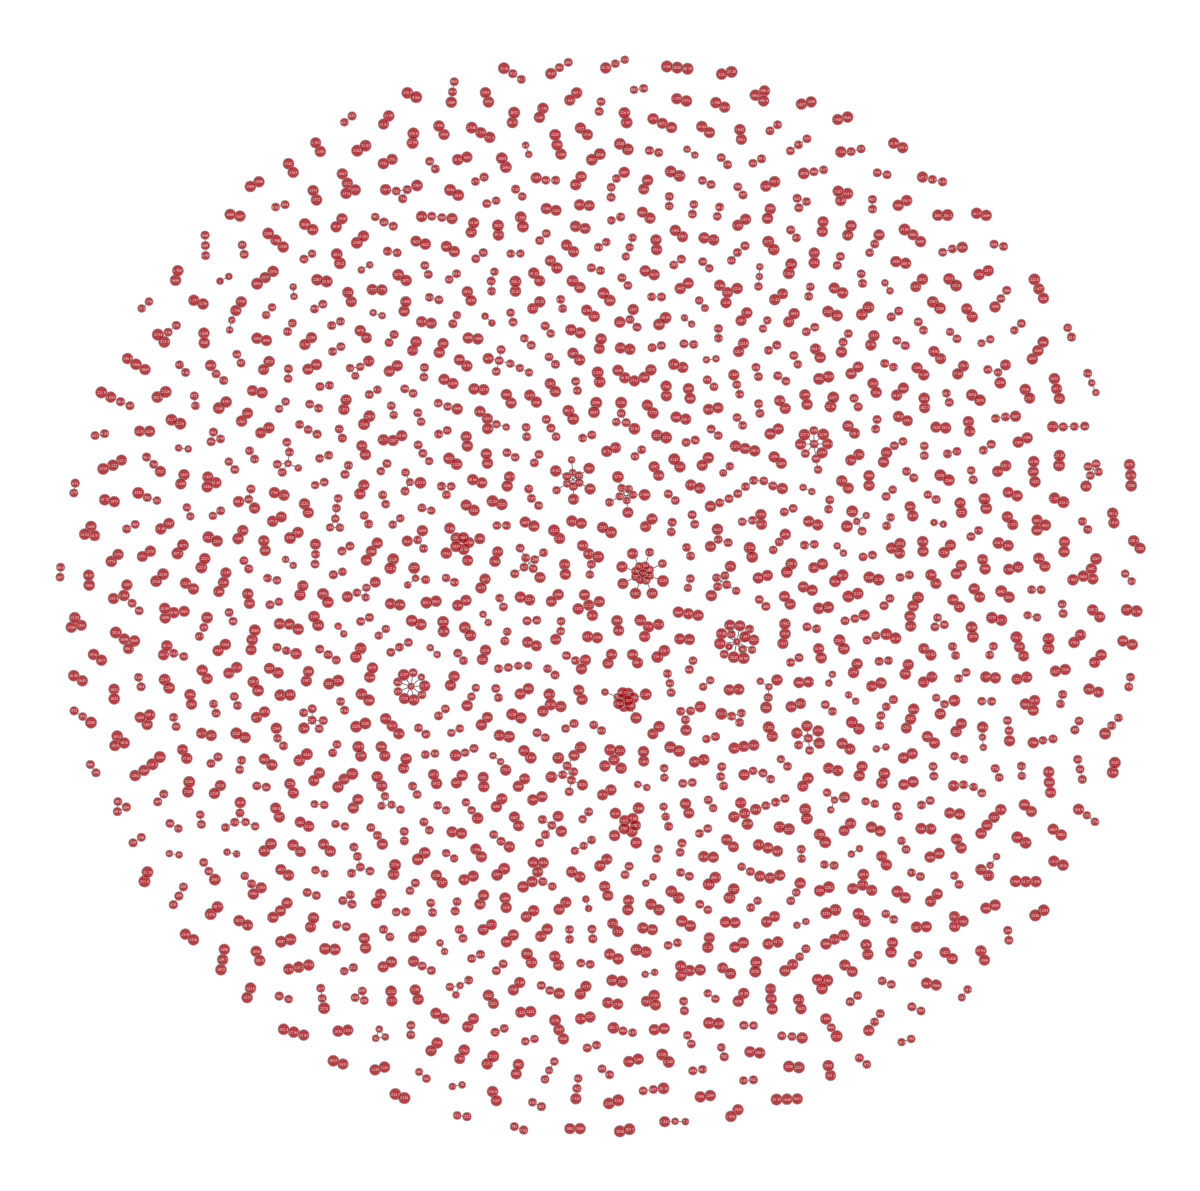

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x28c677c40, at 0x28c689fd0>

In [1146]:
from graph_tool import draw
draw.graph_draw(graph_of_correspondences, vertex_text=graph_of_correspondences.vertex_index)


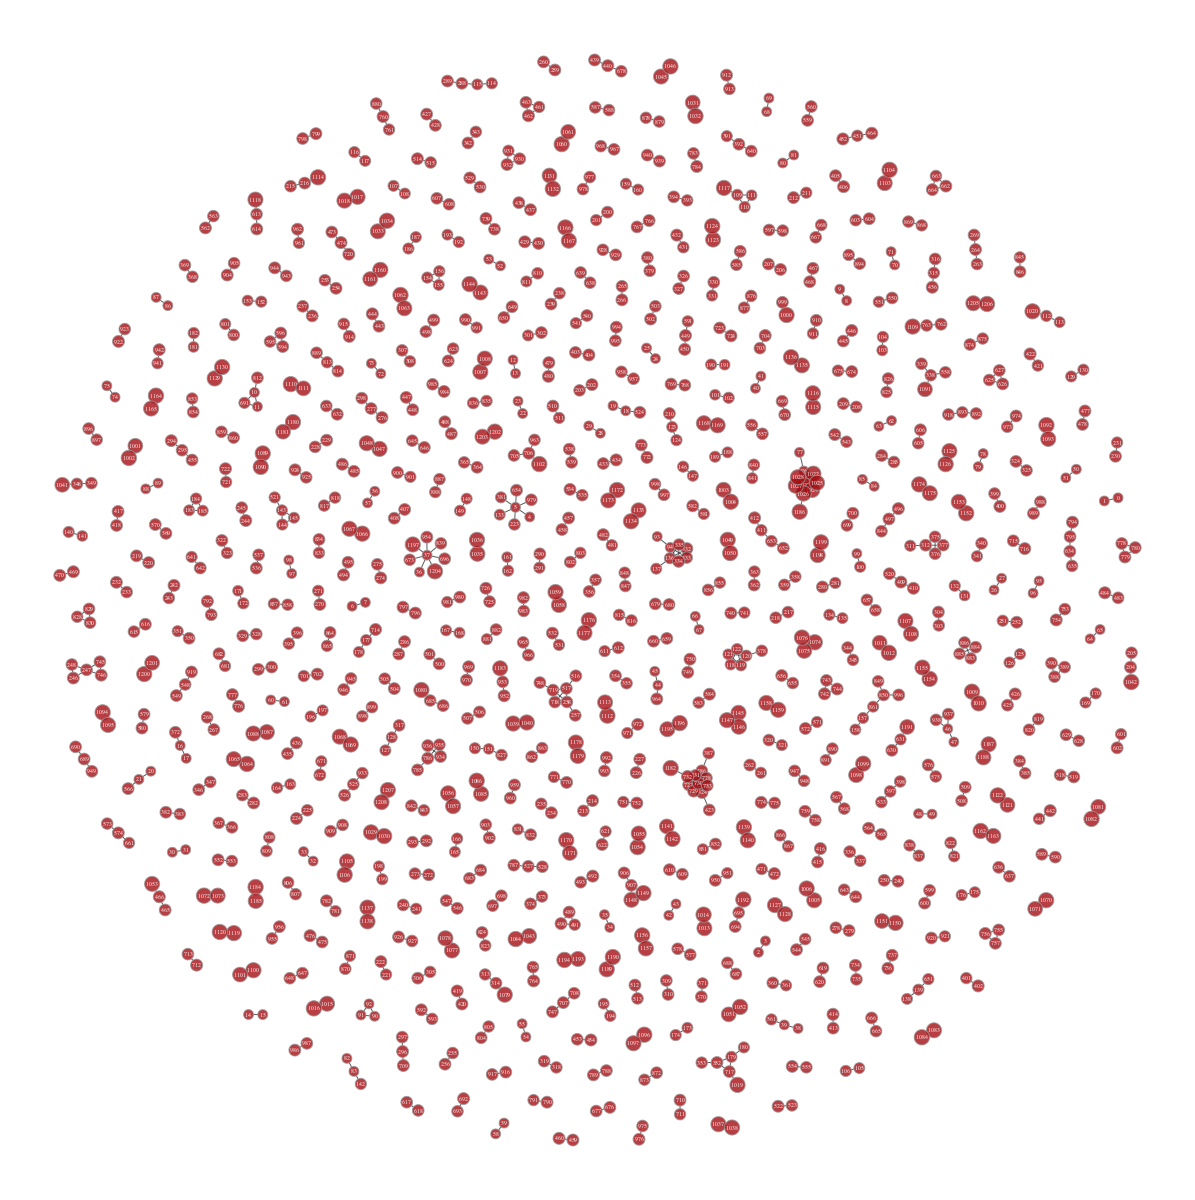

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x28c68b070, at 0x28c665280>

In [1147]:
g1 = gt.Graph( directed=False )
nodes_dict_1 = {}
n = int((df_trial.shape[0])/2)

# Setting properties of graph
vertex_property_1 = g1.new_vertex_property("string")
edge_property_1 = g1.new_edge_property("object")

df_trial[0:n].apply(
                add_correspondence, 
                graph_of_correspondences=g1, 
                ip_addrs_idx = 0, 
                op_addrs_idx = 2, 
                ip_amt_idx = 1, 
                op_amt_idx = 3,
                nodes_dict = nodes_dict_1,
                vertex_property = vertex_property_1,
                edge_property = edge_property_1,
                heuristic = 'h0+h1',
                axis=1
            )


vertices_mapping_1 = []
for i in range(g1.num_vertices()):
    vertices_mapping_1.append({'address' : vertex_property_1[i], 'address_id' : i})
df1 = pd.DataFrame.from_dict(vertices_mapping_1, orient='columns')
df1.to_csv('../../logs/sample_logs/generated_files/1_address_ids.csv', index=False)

edge_mapping_1 = []
for e in g1.edges(): 
    edge_mapping_1.append(edge_property_1[e])
df1 = pd.DataFrame.from_dict(edge_mapping_1, orient='columns')
df1.to_csv('../../logs/sample_logs/generated_files/1_edge_data.csv', index=False)


components_1 = compute_components(g1)
draw.graph_draw(g1, vertex_text=g1.vertex_index)


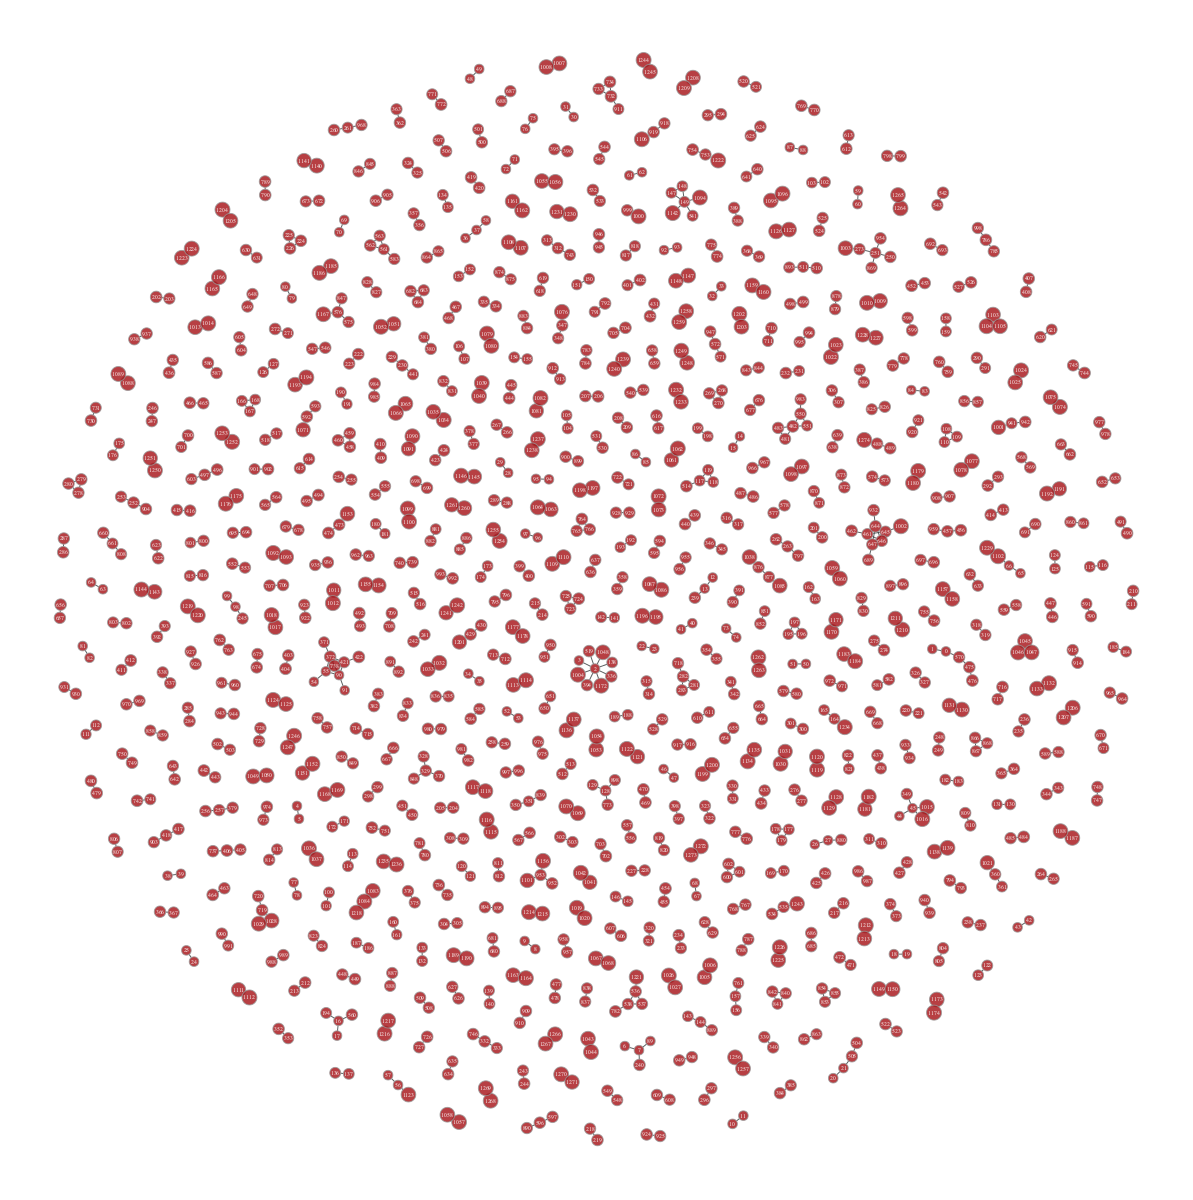

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x28c688370, at 0x28c66d190>

In [1148]:
g2 = gt.Graph( directed=False )
nodes_dict_2 = {}

# Setting properties of graph
vertex_property_2 = g2.new_vertex_property("string")
edge_property_2 = g2.new_edge_property("object")

df_trial[n:df_trial.shape[0]].apply(
                        add_correspondence, 
                        graph_of_correspondences=g2, 
                        ip_addrs_idx = 0, 
                        op_addrs_idx = 2, 
                        ip_amt_idx = 1, 
                        op_amt_idx = 3,
                        nodes_dict = nodes_dict_2,
                        vertex_property = vertex_property_2,
                        edge_property = edge_property_2,
                        heuristic = 'h0+h1',
                        axis=1
            )

vertices_mapping_2 = []
for i in range(g2.num_vertices()):
    vertices_mapping_2.append({'address' : vertex_property_2[i], 'address_id' : i})
df2 = pd.DataFrame.from_dict(vertices_mapping_2, orient='columns')
df2.to_csv('../../logs/sample_logs/generated_files/2_address_ids.csv', index=False)

edge_mapping_2 = []
for e in g2.edges(): 
    edge_mapping_2.append(edge_property_2[e])
df2 = pd.DataFrame.from_dict(edge_mapping_2, orient='columns')
df2.to_csv('../../logs/sample_logs/generated_files/2_edge_data.csv', index=False)

components_2 = compute_components(g2)
draw.graph_draw(g2, vertex_text=g2.vertex_index)


In [1149]:
df_addrs_1 = pd.read_csv('../../logs/sample_logs/generated_files/1_address_ids.csv')
df_addrs_2 = pd.read_csv('../../logs/sample_logs/generated_files/2_address_ids.csv')
df_edge_1 = pd.read_csv('../../logs/sample_logs/generated_files/1_edge_data.csv')
df_edge_2 = pd.read_csv('../../logs/sample_logs/generated_files/2_edge_data.csv')


In [1150]:
# def concat_addrs_data(df1, df2):

#     # change address id in df2 as per df1. df1 address ids remain the same.

#     df2['correct_address_id'] = df2['address_id']

#     for idx, row in df1.iterrows():
#         addrs = row[0]
#         id = row[1]

#         if addrs in list(df2['address']): 

#             df2.loc[df2['address'] == addrs, 'correct_address_id'] = id
#             df2.loc[df2['address_id'] == id, 'correct_address_id'] = int(df2.loc[df2['address'] == addrs, 'address_id'])

#         else:
            
#             df2.reset_index(drop=True, inplace=True)
#             print('address_id: ', addrs, 'max_df2_address_id: ', df2['address_id'].max())
#             df2.loc[df2['address_id'] == id, 'correct_address_id'] = df2['address_id'].max() + 1
#             # df2.loc[df2['address_id'] == id, 'correct_address_id'] = max(df2.index)
            
#             df2 = pd.concat([df2, df1[df1['address'] == addrs]])
#             df2.loc[df2['address'] == addrs, 'correct_address_id'] = id
            

#     df2.reset_index(drop=True, inplace=True)
#     df2 = df2.convert_dtypes()
    
#     # df = df2[['address', 'correct_address_id']].copy()
#     # df.rename(columns={'correct_address_id': 'address_id'}, inplace=True)

#     return df2


def change_node_ids(df_edge, df_addrs):

    for idx, row in df_edge.iterrows():
        node1 = int(row[0])
        node2 = int(row[1])

        new_node1 = df_addrs.loc[df_addrs['address_id'] == node1, 'correct_address_id']
        new_node2 = df_addrs.loc[df_addrs['address_id'] == node2, 'correct_address_id']

        # if there are more than one rows with same previous address_id, then select the one where 
        # previous address id is not same as the correct_address_id
        # this is because edge data of df2 does not have the nodes from df1 that were initially not present in df2

        if len(new_node1) > 1:
            new_node1 = df_addrs.loc[(df_addrs['address_id'] == node1) & 
                                                    (df_addrs['address_id'] != df_addrs['correct_address_id'])]
            df_edge.loc[df_edge['node1'] == node1, 'correct_node1'] = int(new_node1['correct_address_id'])
        else:
            df_edge.loc[df_edge['node1'] == node1, 'correct_node1'] = int(new_node1)

        if len(new_node2) > 1:
            new_node2 = df_addrs.loc[(df_addrs['address_id'] == node2) & 
                                                    (df_addrs['address_id'] != df_addrs['correct_address_id'])]
            df_edge.loc[df_edge['node2'] == node2, 'correct_node2'] = int(new_node2['correct_address_id'])
        else:
            df_edge.loc[df_edge['node2'] == node2, 'correct_node2'] = int(new_node2)

    return df_edge



def concat_edge_data(df_edge, df_edge_nodes_swapped):
    
    df_stacked = pd.concat([df_edge, df_edge_nodes_swapped], axis=0)
    df_stacked.reset_index(drop=True, inplace=True)
    df = df_stacked.groupby(['node1', 'node2'], as_index=False)[list(set(df_stacked.columns) - set(['node1', 'node2']))].sum()
    df.loc[df['h0'] > 0 , 'h0'] = 1
    df.loc[df['h1'] > 0 , 'h1'] = 1

    return df



In [1151]:
df_2 = df_addrs_2.copy()


In [1152]:
def concat_addrs_data(df1, df2):
    
    df2['correct_address_id'] = np.nan

    for idx, row in df1.iterrows():
        addrs = row[0]
        id = row[1]

        if addrs in list(df2['address']): # Address is in both df1 and df2

            # assign id of 'addrs' from df1 to correct_address_id of 'addrs' in df2
            df2.loc[df2['address'] == addrs, 'correct_address_id'] = id

        else: # Address that are in df1 but not in df2 are concatenated to df2
            
            df2 = pd.concat([df2, df1[df1['address'] == addrs]])
            df2.loc[df2['address'] == addrs, 'correct_address_id'] = id

    df2.reset_index(drop=True, inplace=True)
    df2 = df2.convert_dtypes()

    # Assign correct_address_id to remaining addresses in df2
    idx_list = list(set(df2.index) - set(df2['correct_address_id'])) # remaining idx values that haven't been used as ids
    df2.loc[df2['correct_address_id'].isna(), 'correct_address_id'] = idx_list

    return df2


In [1153]:
def concat_addrs_edge(df_addrs_1, df_addrs_2, df_edge_1, df_edge_2):

    # step 1: concat both address dataframes and get new ids for nodes
    df_addrs_concat = concat_addrs_data(df_addrs_1, df_addrs_2)

    # step 2: get correct ids for node1 and node2 in edge data of second dataframe
    df_edge_2['correct_node1'] = df_edge_2['node1']
    df_edge_2['correct_node2'] = df_edge_2['node2']
    df_edge_new_node_ids = change_node_ids(df_edge_2, df_addrs_concat)

    # step 3: rename columns of above edge data of second dataframe
    df_edge_new_node_ids.drop(['node1', 'node2'], axis = 1, inplace=True)
    df_edge_new_node_ids.rename(columns={'correct_node1' : 'node1', 'correct_node2' : 'node2'}, inplace=True)

    # step 4: concatenate edge data of both dataframes
    df_edge_concat = concat_edge_data(df_edge_1, df_edge_new_node_ids)

    # step 5: rename columns of concatenated address dataframe from step 1
    df_addrs_concat.drop(['address_id'], axis = 1, inplace=True)
    df_addrs_concat.rename(columns={'correct_address_id' : 'address_id'}, inplace=True)

    return df_addrs_concat, df_edge_concat


In [1154]:
df_addrs_concat, df_edge_concat = concat_addrs_edge(df_addrs_1, df_addrs_2, df_edge_1, df_edge_2)


In [1155]:
df_addrs_concat


,address,address_id
0,3e759fe07fd1965b23fee52841651d6026c046597be309...,2048
1,1c8b35f19d1c1a277eb1081d6cec4e62e951266283027a...,2049
2,4e639b9b2498d708f4473cb9da8102e20fbfd51b650f7e...,5
3,0c5d2ffe2fba6b08bf8410ee263d18be057d9c8ef2b840...,2050
4,26ce3d9ce8c32793aca0864098d18c9fb3bae60113bd95...,2051
...,...,...
2331,31fc66ce5d867029843f1d623adbd376148c2545f9bbac...,1203
2332,d384efa6de12ae779884fcda9279c3b3001a9976833b71...,1204
2333,5b16428c176dc28a7104520caa1839cd8db4fd329adcf4...,1205
2334,e573a942eecbe065fb7b1e5a5ebb61839fc4407a316f9b...,1206


In [1156]:
df_edge_concat


,node1,node2,h0,count_of_same_edge_h0,h1,count_of_same_edge_h0_h1
0,0,1,1,1,1,1
1,2,3,1,1,1,1
2,4,5,1,1,1,1
3,5,133,1,1,1,1
4,5,381,1,1,1,1
...,...,...,...,...,...,...
1517,2330,2331,1,1,1,1
1518,2332,2333,1,1,1,1
1519,2333,967,1,1,1,1
1520,2333,1245,1,1,1,1


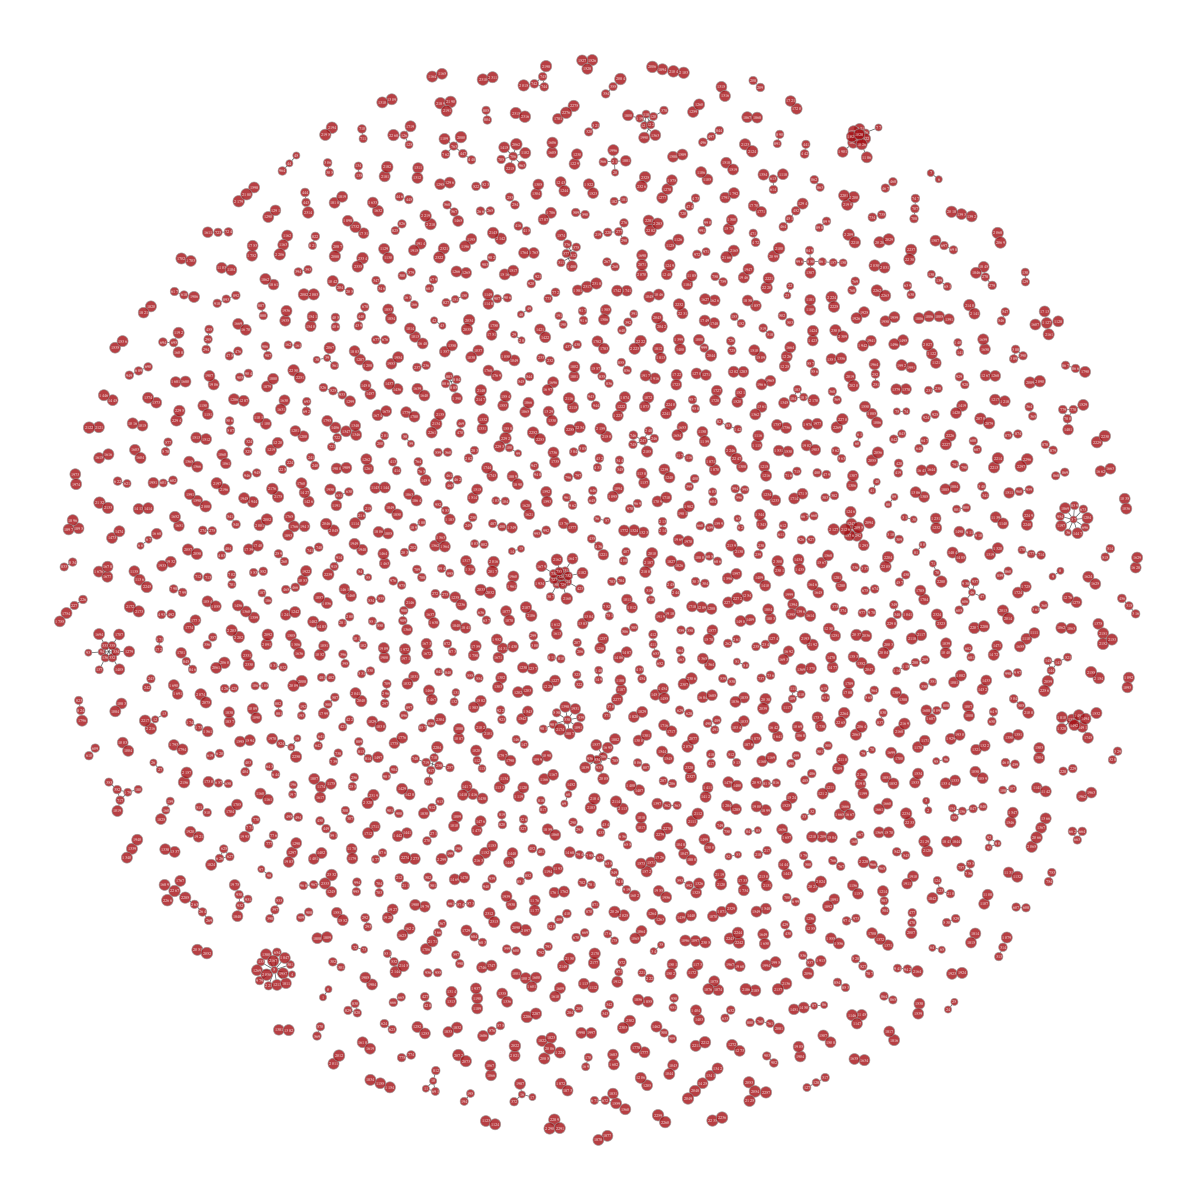

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x28c688640, at 0x28c75b460>

In [1157]:
def make_g(g, df_addrs_concat, df_edge_concat):

    for node in df_addrs_concat['address_id'] :
        vertex = g.add_vertex()

    for idx, row in df_edge_concat.iterrows():
        v0 = row[0]
        v1 = row[1]
        e = g.add_edge(v0,v1)
        
    return g

g = gt.Graph( directed=False )
make_g(g, df_addrs_concat, df_edge_concat)
draw.graph_draw(g, vertex_text=g.vertex_index)
